# Using Giovanni to Detrend and Visualize Significance of Individual Points on a Time Series
***

### These features would allow users to shade a 95% confidence interval based on a one-sample t-test a time series to quickly answer questions based on the significance of a data point in a time series. And for users that are interested in changes in the intra-annual (seasonal) variability of variables through time, detrended time series are a great way to visualize this (i.e., is the seasonal cycle of temperature in Maine becoming more variable through time?) 

### The following example shows an example using 30 years of Monthly MERRA-2 Surface Skin Temperatures (or SST for over the ocean) over the waters off of Coastal Louisiana from August to examine whether there years where the SST is significantly different from the 30-yr average. 

***

### This notebook requires the following python packages and their dependencies installed. 

__Required:__
- numpy
- pandas
- xarray
- matplotlib
- scipy
- glob (for gathering list of .nc4 files)

___Used for Plotting (Optional):___
- cmaps (NCL Colormaps)
- cartopy

#### GES DISC Data Used in Example 

In this example we use 30 Years (1995-2024) of Monthly MERRA-2 Surface Skin Temperature downloaded using from the [M2TMNXSLV_5.12.4 dataset](https://disc.gsfc.nasa.gov/datasets/M2TMNXSLV_5.12.4/summary). 

We subset the Monthly Data by accessing the [dataset landing page](https://disc.gsfc.nasa.gov/datasets/M2TMNXSLV_5.12.4/summary), selecting Subset / Get Data via OPeNDAP using a small region off the coast of Louisiana and selecting the "surface_skin_temperature" variable. 



##### Importing Libraries

In [2]:
import glob
import numpy as np
import xarray as xr
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import cmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

##### Gather list of monthly data files and open in Xarray

In [3]:
#List of Monthly Files From MERRA-2 (1995-2024)
files_SST = glob.glob ('C:/Users/bomitch1/Downloads/Giovanni_Stats_Examples/3/M2TMNXSLV*.nc4.nc4')

#Open Dataset
SST_da = xr.open_mfdataset(files_SST)['TS']
print(SST_da)

<xarray.DataArray 'TS' (time: 361, lat: 4, lon: 8)> Size: 46kB
dask.array<concatenate, shape=(361, 4, 8), dtype=float32, chunksize=(1, 4, 8), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 64B -93.75 -93.12 -92.5 ... -90.62 -90.0 -89.38
  * time     (time) datetime64[ns] 3kB 1995-06-01T00:30:00 ... 2025-06-01T00:...
  * lat      (lat) float64 32B 28.0 28.5 29.0 29.5
Attributes:
    long_name:       surface_skin_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]


## Detrending Time Series

##### We are interested in August SST's near Coastal Louisiana because this can be a large indicator of whether a landfalling hurricane will rapidly strengthen or weaken right before landfall. 

In [4]:
#Select only June Months
Aug_SST = SST_da.sel(time=SST_da['time.month'] ==8)
print(Aug_SST)

<xarray.DataArray 'TS' (time: 30, lat: 4, lon: 8)> Size: 4kB
dask.array<getitem, shape=(30, 4, 8), dtype=float32, chunksize=(1, 4, 8), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 64B -93.75 -93.12 -92.5 ... -90.62 -90.0 -89.38
  * time     (time) datetime64[ns] 240B 1995-08-01T00:30:00 ... 2024-08-01T00...
  * lat      (lat) float64 32B 28.0 28.5 29.0 29.5
Attributes:
    long_name:       surface_skin_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]


##### Now we will plot a map to double check that this is the correct region we want to investigate. 

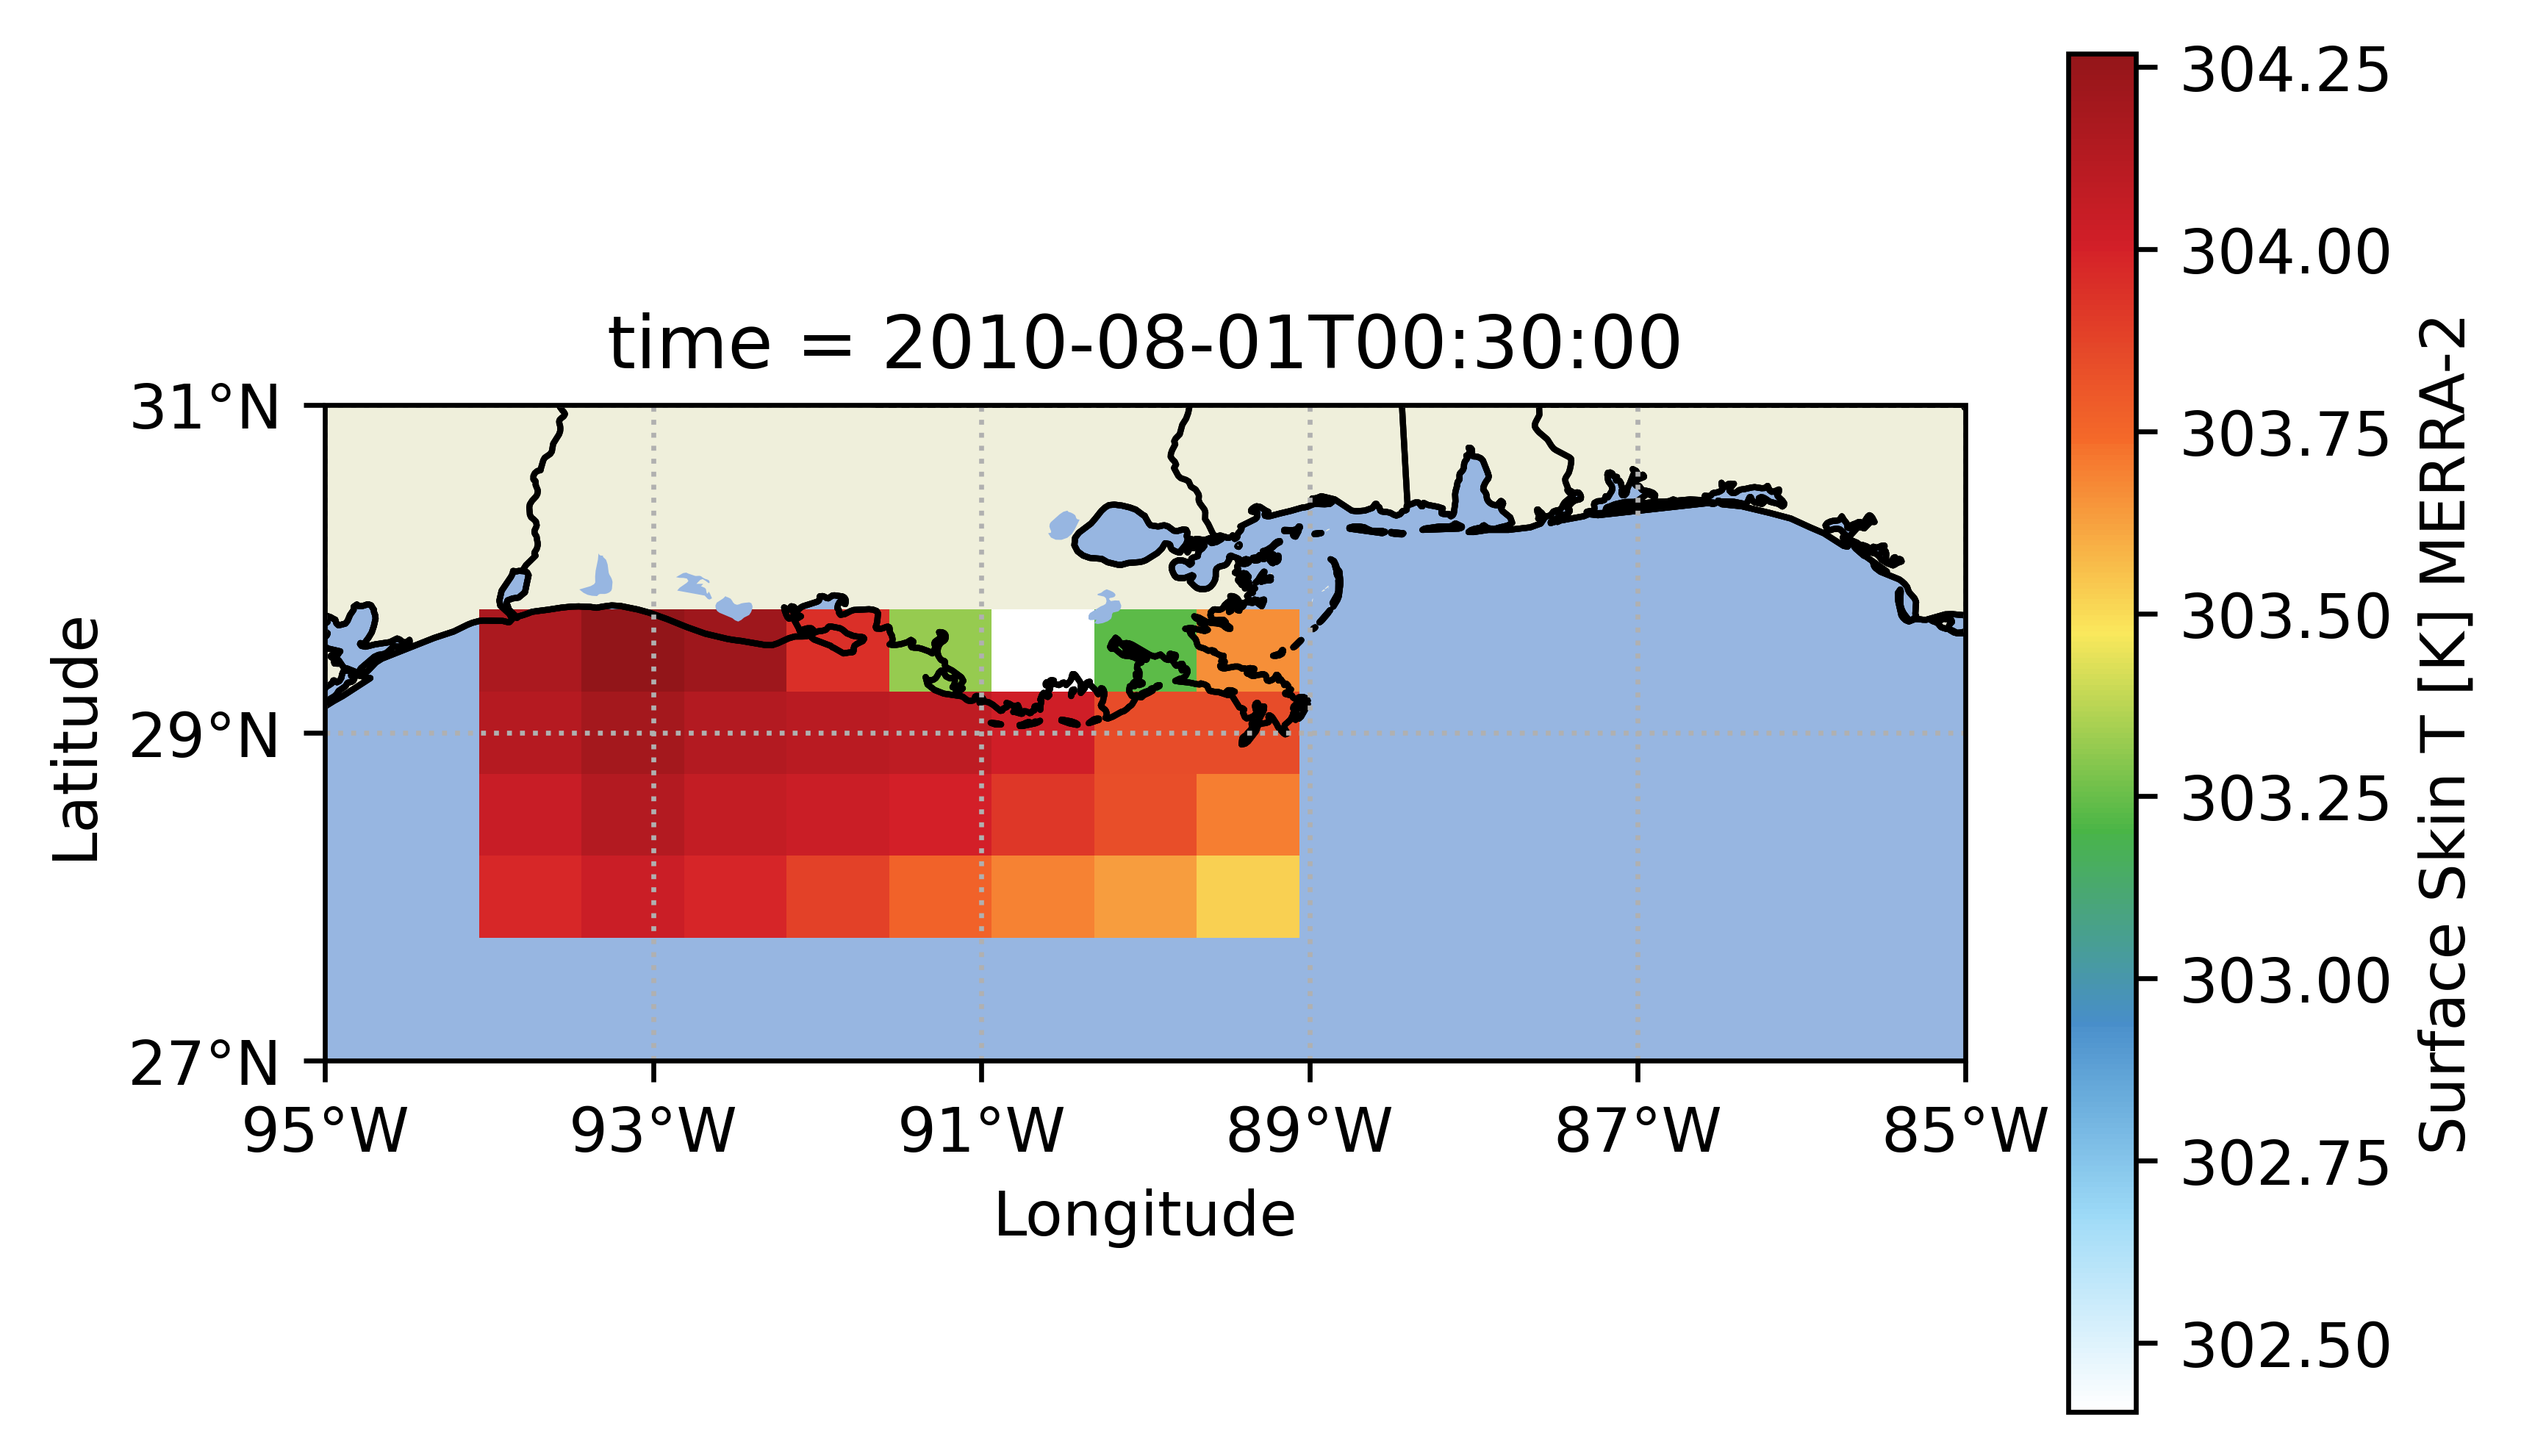

In [5]:
#Plotting the Map of Coastal Louisiana Area
fig, axs = plt.subplots(1,1,figsize=(6,4),subplot_kw={"projection": ccrs.PlateCarree()},
                          dpi=600)
ax1 = plt.subplot(1,1,1)

#Set Map Extent
ax1.set_extent([-95, -85, 27, 31])

#Add Map Features
ax1.coastlines(resolution='10m')
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.LAKES)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.STATES, edgecolor='black')
ax1.grid(linestyle='dotted')

#Create and Format Ticks
ax1.set_yticks(np.arange(27,32,2), crs=ccrs.PlateCarree())
ax1.set_xticks(np.arange(-95,-84,2), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

#Plot Values on Map
grid = Aug_SST[15].plot.imshow(ax=ax1,cmap=cmaps.WhiteBlueGreenYellowRed,add_colorbar=False)

#Add Colorbar 
cb = plt.colorbar(grid, ax=ax1, orientation = 'vertical', label='Surface Skin T [K] MERRA-2')

#Add plot X and Y axis labels and designate tick fontsizes. 
ax1.set_xlabel("Longitude",  size=10)
ax1.set_ylabel("Latitude", size=10)
ax1.tick_params(axis='x', labelsize=10)  
ax1.tick_params(axis='y', labelsize=10) 

##### To compute the time series area-average we need to compute the average of all the grid boxes at each time step (30 steps)

##### We will take the mean, however we need to make sure we weight our data by the cosine of the latitude to account for the differences in the area each grid box covers. For an area this small it will not make as much of a difference, however, area averages that span a large latitudinal range need to be weighted by the cosine to properly compute the areal mean. 

Below we compute the area average using the [cosine weighting in xarray](https://docs.xarray.dev/en/latest/examples/area_weighted_temperature.html) to produce the time series of August SSTs over the waters of Coastal Louisiana from 1995-2024. 

In [6]:
#Average Area (Cosine)
weights = np.cos(np.deg2rad(Aug_SST.lat)) 
weights.name = "weights"
SST_weighted = Aug_SST.weighted(weights)
SST_weighted_mean = SST_weighted.mean(("lon", "lat"))

##### Let's plot the time series below. 

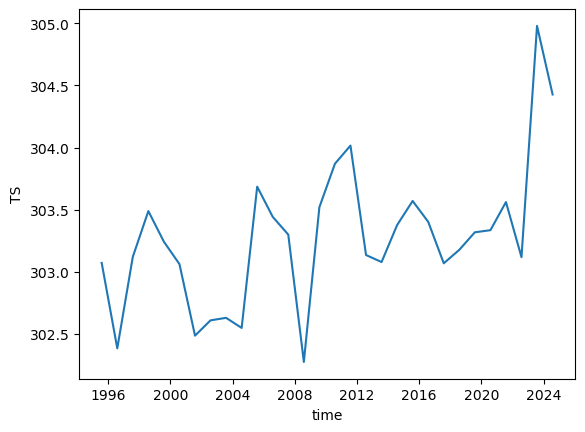

In [8]:
SST_weighted_mean.plot()

##### Next let's do the linear regression of the data to compute the trendline. 

##### We will utilize SciPy's linear regression package (scipy.stats.linregress) which takes an array of x (time) and y (August SST's) data, computes the linear regression and returns the slope, y-intercept, pearson coefficient (r), p-value, and standard error. 

##### For our purpose in this exercise we only need the slope and intercept data to compute the trendline.  

In [15]:
# Compute linear regression using scipy.
# We use pandas datetime capabilities to extract the year from each time step so the year becomes our independent variable. 
# The values plotted above are contained within xarray's dataarray so we need to call those values using .values 
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pd.to_datetime(SST_weighted_mean.time).year,
                                                               SST_weighted_mean.values)
print(f"The slope of the line is {slope:.2f}" + f" and the y intercept is {intercept:.2f}")

The slope of the line is 0.03 and the y intercept is 232.98


##### Next let's prepare to plot our trendline by creating a trendline with our dates on the x axis (years) and our dependent variable y depends on the input of x given y = slope*x + y-intercept.

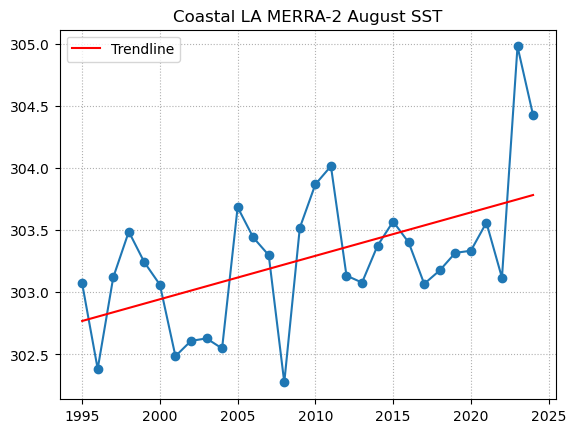

In [18]:
trendline_x = np.linspace(min(pd.to_datetime(SST_weighted_mean.time).year), 
                          max(pd.to_datetime(SST_weighted_mean.time).year), len(SST_weighted_mean))

trendline_y = slope * trendline_x + intercept

#Plotting trendline with time series
plt.plot(pd.to_datetime(SST_weighted_mean.time).year, SST_weighted_mean.values, marker='o')
plt.plot(trendline_x, trendline_y, color='red', label='Trendline')
plt.xlabel('Year')
plt.ylabel('SST [K]')
plt.title('Coastal LA MERRA-2 August SST')
plt.grid(linestyle='dotted')
plt.legend(loc='upper left') 



##### Now our data and trendline shows indicates that there's increasing SST's over Coastal Louisiana over this time period. 

However, we would need additional statistics and analysis to come to a more robust conclusion. 

##### If we were not interested in the overall trend but wanted to investigate the seasonality of data, this is best done with a detrended time series to remove the increasing expected value over time. 

Below we detrend the data by subtracting the red line from all of the blue data points. 

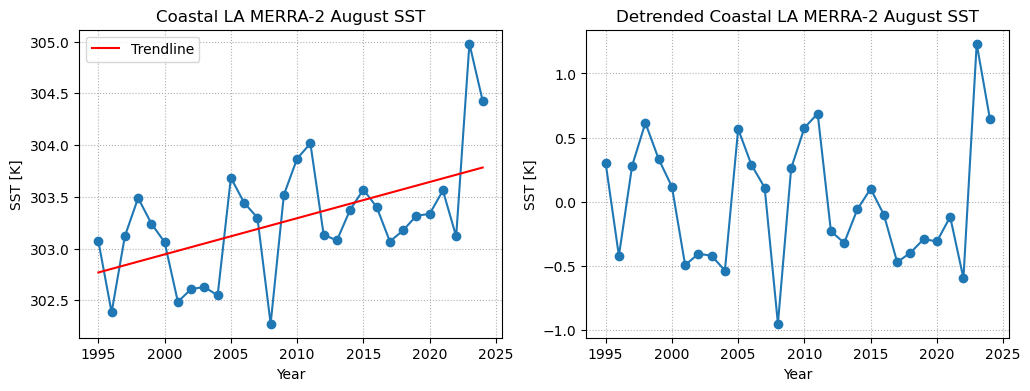

In [24]:
detrended_SST = SST_weighted_mean.values - trendline_y

#Plotting
plt.subplots(1,2,figsize=(12,4))

#Original Data with Trendline
plt.subplot(121)
plt.plot(pd.to_datetime(SST_weighted_mean.time).year, SST_weighted_mean.values, marker='o')
plt.plot(trendline_x, trendline_y, color='red', label='Trendline')
plt.xlabel('Year')
plt.ylabel('SST [K]')
plt.title('Coastal LA MERRA-2 August SST')
plt.grid(linestyle='dotted')
plt.legend(loc='upper left') 

#Detrended Time Series
plt.subplot(122)
plt.plot(pd.to_datetime(SST_weighted_mean.time).year, detrended_SST, marker='o')
plt.xlabel('Year')
plt.ylabel('SST [K]')
plt.title('Detrended Coastal LA MERRA-2 August SST')
plt.grid(linestyle='dotted')

## Significance Testing via 2-sided One Sample Student's t test and 95% Confidence Interval 

### To compute the significance of any one data point using a two-sided student's t test we need the following information. Much of which we already have since we can plot time series in Giovanni.

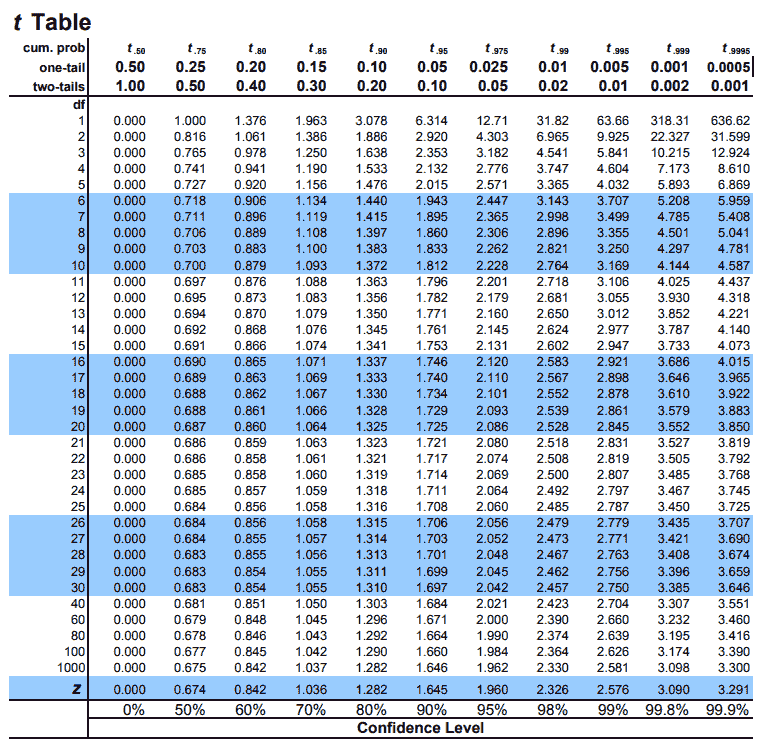

#### Computing a t-score by hand can be a bit labourous given the need for a look-up table which depends on what probability you are testing (p) and the number of samples to compute the degrees of freedom (n - 1). Python's scipy.stats package retrieves the t-value given a p-value and degrees of freedom. 

#### We can substitute the t-value in for the z-score and compute the upper and lower bounds of the confidence interval, which using python we can shaded the region in between to let users quickly visualize which points are significant in a time series with respect to the mean of the time series. 

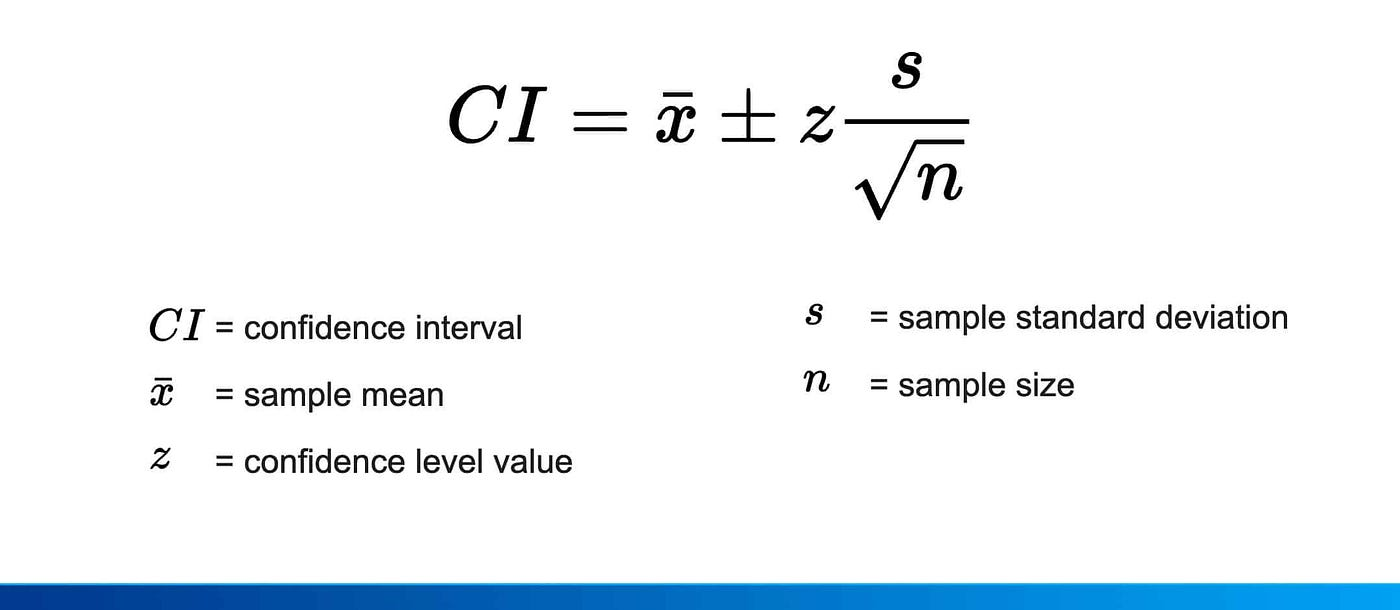.

[medium.com](https://medium.com/@abhishekjainindore24/insights-about-significance-level-and-confidence-level-confidence-interval-and-two-tail-vs-one-40c1646c6a23)

#### Below we compute the mean, standard deviation, standard error of the monthly August SST's from 1995-2024 for Coastal Lousiana. Then we use a p-value of 0.05 and number of samples to retrieve the corresponding t-value and compute the confidence interval upper and lower bounds.

In [25]:
# Computing 95% Confidence Interval (CI)

# Computing the mean, standard deviation, and number of samples in the population
m, s, n = np.mean(SST_weighted_mean.values), np.std((SST_weighted_mean.values), ddof=1), len(SST_weighted_mean.values) 

# A p-value of 0.05 corresponds to the probability of the critical threshold to test the significance of any of the August SST's
p=0.05

# Using SciPy stats to retrieve the t-value, note that (1.00 - 0.05 = 0.95), however we need to divide the p-value by 2 
# because we need to account for extremes on both ends of the distribution, in this case significantly warm or cold SST's in August. 
t = scipy.stats.t.ppf(1-p/2, df=n-1)  #  The degrees of freedom for a one-sample t test is (n - 1)

# Computing the standard error (e) which is the expression to the right of the +/- sign above. 
e = t * (s / np.sqrt(n))

# The upper bound of the confidence interval is given by the full expression above 
# by adding the mean and standard error multplied by the t-score
upper_bound = m + e 

# The lower bound of the confidence interval is given by the full expression above 
# by subtracting the standard error multplied by the t-score from the mean
lower_bound = m - e 

print(lower_bound, upper_bound) 

303.0600681551138 303.4920442262948


##### Plotting the time series will reveal which points are signifcant since those will be outside the shaded upper and lower bounds. This is the feature I ultimately think we should add as an option to plot. 

##### Below we have the histogram on the left showing the distribution (it's not quite gaussian/normal, but for this example it's close enough to consider the analysis valid.).

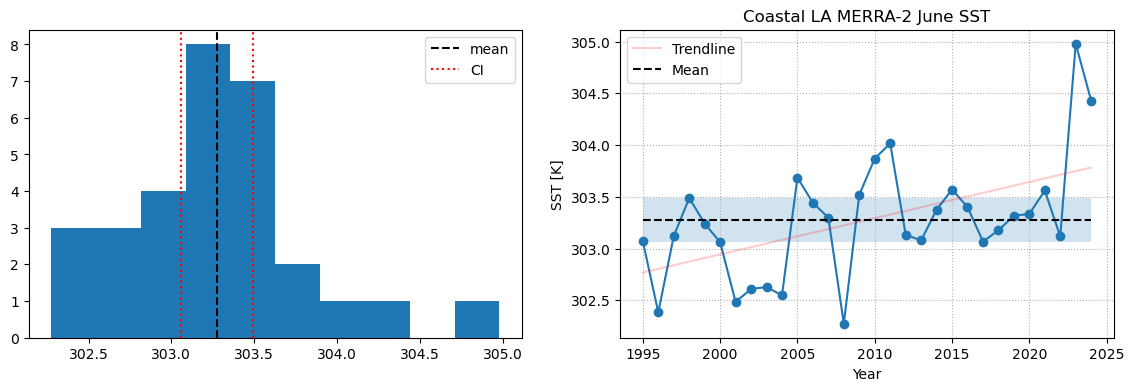

In [34]:
#Plotting
plt.subplots(1,2,figsize=(14,4))

#Histogram of Distribution of August Monthly SST's
plt.subplot(121)
plt.hist(SST_weighted_mean.values)
plt.axvline(m,zorder=10,color='k',linestyle='dashed',label='mean')
plt.axvline(upper_bound,
                    zorder=10,color='r',linestyle='dotted',label='CI')
plt.axvline(lower_bound,
                    zorder=10,color='r',linestyle='dotted')
plt.legend()

#Time series with 95% CI shading. 
plt.subplot(122)
plt.plot(pd.to_datetime(SST_weighted_mean.time).year, SST_weighted_mean.values, marker='o')
plt.plot(trendline_x, trendline_y, color='red', label='Trendline',alpha=0.2)
plt.xlabel('Year')
plt.ylabel('SST [K]')
plt.title('Coastal LA MERRA-2 June SST with 95% CI')
plt.fill_between(pd.to_datetime(SST_weighted_mean.time).year, 
                 upper_bound, 
                 lower_bound, 
                 alpha=0.2)
plt.grid(linestyle='dotted')
#Adding a line for the Mean onto the plot
plt.plot(pd.to_datetime(SST_weighted_mean.time).year,(np.ones(len(SST_weighted_mean))*np.mean(SST_weighted_mean.values)),
         color='k',linestyle='dashed',label='Mean')
plt.legend(loc='upper left')

#### Above we can see how shading the area can help users see with their eyes which years are significant based on the one sample, two-sided student's t test. It is important to note that this was 30 years (or samples) worth of data and many things need to be considered when performing statistical analysis. 

1. The data should be continous and not discrete. 
2. The data should be independent. In this case we looked a SST's in different years not individual values for consective months since the SST's do have memory.
3. The data are normally distributed. In this case they generally are, but there is some skewness on both sides, especially including the very extreme values.

#### Nonetheless, adding this feature into Giovanni I think would be a good way to give users a visual of significant points in their monthly or yearly time series. "